# To Do list for this notebook (and other stuff)
- anyone: feel free to edit my (Andi) code or text. Specifically, I'm not that experienced with python and i'm sure some of my operations can be made more elegantly
- add info what "status" means in the output .json to respective section
- why does the output .json explicitly return the independence model only in the oMHN case? What's the difference?
- add use of save_progress() function. Can it also be used during find_lambda() or only during train()?
- adjust the theta plotting function to have text labels properly sized
- i think (not sure) the .plot() method applies the threshold for per-cell label plotting also to the diagonal. I propose we label either all or no baserates
- make reproducible with seeds
- right now for getting a random data subset, I use a specific seed to avoid samples with >5 events to limit CV computation time. Better ideas?
- why is the cv'd lambda I get for oMHN not contained in the input sequence? Also the one for cMHN is slighly different. 
- i would prefer the .save() method to default to overwrite, not to Error out if the file already exists (maybe it's just me)
- what would happen if we simulate starting from a state that has a large observation rate? Would the simulations largely return the original state?
- should we add demo to compute marginal likelihood of a state? What would be an obvious example use case?
- the tables returned by compute_next_event_probs(allow_observation=True) do not include the observation event explicitly (although I think they do get the calculations right)
- should we add a troubleshooting section? What are some common situations where stuff can go wrong?

# `mhn` Demonstration

In this notebook, we will demonstrate a basic workflow for using the `mhn` python package. As exemplary data, we use somatic mutations in 12 driver genes of lung cancer patients. A similar analysis has been conducted on the same dataset in the publication __[Overcoming Observation Bias for Cancer Progression Modeling](https://www.biorxiv.org/content/10.1101/2023.12.03.569824v1)__ and was originally obtained through __[AACR GENIE](https://doi.org/10.7303/syn51355584)__. 

In the following sections, we will
1. [Check the necessary installations](#confirming-package-functionality)
2. [Load and inspect input data](#loading-and-inspecting-input-data)
3. [Prepare for MHN training](#preparation-for-mhn-training)
    1. [Choose a framework](#choosing-the-mhn-framework)
    2. [Choose a penalty](#choosing-the-regularization-penalty)
    3. [Prepare for cross-validation](#choosing-the-regularization-penalty)
    4. [Choose a processing device](#choosing-the-processing-device)
4. [Execute MHN training with cross-validation](#executing-mhn-training)
    1. [Perform cross-validation](#cross-validation)
    2. [Train the final models](#final-model-training)
5. [Inspect the primary MHN output - the Θ-matrix](#inspecting-the-θ-matrix)
6. [Simulate artifical data from the trained models...](#simulating-artificial-data-from-a-mhn)
    1. [... to evaluate fit quality](#evaluating-mhn-fitting-quality)
    2. [... to explore event orderings](#exploring-event-orderings)
7. [Make next-event predictions using MHN inferences](#predicting-the-next-event-for-a-given-mhn-state)

## Confirming package functionality

This notebook assumes that the package has been installed via `pip install mhn`. We can confirm the functionality of the installation with

In [1]:
try:
    import mhn
    print("mhn is installed")
except ImportError:
    print("mhn installation not found")

mhn is installed


We can now make all MHN imports necessary for this notebook:

In [2]:
from mhn.optimizers import OmegaOptimizer, StateSpaceOptimizer
from mhn.model import MHN

If available, a Nvidia GPU may be used to accelerate MHN training. Apart from the GPU itself, this requires a functional installation of __[CUDA and the CUDA compiler nvcc](https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/)__. This approach is optional and will be treated as such in the notebook. 
We can check if CUDA is available to MHN with

In [3]:
cuda_status = mhn.cuda_available()
print(cuda_status)

CUDA compiler nvcc was not present during installation


## Inspecting and loading input data

We now import the lung adenocarcinoma dataset. MHN expects a binary matrix (containing only 0s and 1s), with rows representing individual observations (e.g., patients/tumors), columns representing individual events (e.g., per-gene mutations) and cells representing the presence or absence (1s or 0s) of the respective event in the respective observation. Event identifiers may be given as column names. To inspect the input data, we can load it with

In [4]:
import pandas as pd
input = pd.read_csv('LUAD_n12.csv')
input.head()

,TP53,KRAS,EGFR,STK11,RBM10,KEAP1,ATM,SMARCA4,PTPRD,NF1,PIK3CA,BRAF
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0
4,1,0,1,0,0,0,0,0,0,0,0,0


Let us now inspect some basic data stats

In [5]:
print("Number of observations:", len(input))
print("Number of events:", len(input.columns))

Number of observations: 3662
Number of events: 12


In [6]:
print("Event frequencies:")
input.sum(axis=0) / len(input)

Event frequencies:


TP53       0.410705
KRAS       0.341344
EGFR       0.279902
STK11      0.141999
RBM10      0.118788
KEAP1      0.103768
ATM        0.059803
SMARCA4    0.058711
PTPRD      0.057619
NF1        0.057073
PIK3CA     0.049153
BRAF       0.048334
dtype: float64

In [7]:
print("Distribution of active event counts across observations:")
input.sum(axis=1).value_counts().sort_index()

Distribution of active event counts across observations:


0     477
1    1086
2    1327
3     550
4     180
5      37
6       5
Name: count, dtype: int64

The dataset is a little large to be used completely in this notebook, so let's only take a part of the data:

In [8]:
import random
random.seed(6)
input_subset = input.sample(n=500)
input_subset.sum(axis=1).value_counts().sort_index()

0     56
1    149
2    186
3     82
4     20
5      6
6      1
Name: count, dtype: int64

## Preparation for MHN training

In preparation for MHN training, one has to make a few decisions regarding the model framework and cross-validation strategies. We will now guide through these decisions step by step. Afterwards, the actual training process, including cross-validation, will be two simple lines of code.

### Choosing the MHN framework
One can use either the classical MHN framework (**cMHN**, discussed in __[Schill et al. 2020](https://doi.org/10.1093/bioinformatics/btz513)__) or the observation-aware MHN framework (**oMHN**, discussed in __[Schill et al. 2024](https://www.biorxiv.org/content/10.1101/2023.12.03.569824v1)__).<br><br> In brief, the conceptual difference is that oMHN explicitly includes the observation itself as an event. In other words, the time at which a cancer exits (recorded) progression by being observed is dependent on the events that it accumulated before. In contrast, in cMHN this dependence does not exist and instead observation times simply follow an exponential distribution. In practice, choosing oMHN generally does not substantially affect performance in terms of fitting the data, but it likely increases soundness and interpretability of the inferred model parameters. **Thus, we would recommend oMHN in most scenarios.** <br><br>
In terms of code, this decision is made by setting the respective optimizer function. For the example at hand, we will perform a run with each framework:

In [9]:
# for cMHN, we set
cMHN_opt = StateSpaceOptimizer()
# while for oMHN, we set
oMHN_opt = OmegaOptimizer()

Once we have initialised the optimizer object, we can give it the input dataframe:

In [10]:
# load data for the cMHN framework
cMHN_opt.load_data_matrix(input_subset)
# load data for the oMHN framework
oMHN_opt.load_data_matrix(input_subset)

Alternatively, we could have used the `load_data_from_csv()` function to load the input data directly from a .csv.

### Choosing the regularization penalty

Like most machine learning models, MHN uses regularization during the training process. In brief, regularization means penalising the parameter inference so that a sparse (parsimonious) set of parameters is generally preferred. In other words, it aims at explaining the training input data well, with as little parameters as possible, to keep the model generalisable to test data. While the *strength* of the regularization penalty is determined later during cross-validation, we now have to decide on the *form* of regularization. <br><br>
There are two forms of penalty currently implemented for MHN, a **standard L1-penalty** and a **custom symmetrical penalty**. The L1-penalty is a standard approach in machine learning and keeps each parameter uniformly close to 0. In contrast, the symmetrical penalty restricts pairs of parameters simultaneously, specifically pairs which are symmetrical in Θ with respect to the diagonal. Having one such pair of parameters at a nonzero value is as costly as having only one of them at the same value. This is further discussed in __[Schill et al. 2024](https://www.biorxiv.org/content/10.1101/2023.12.03.569824v1)__. **We recommend to choose the penalty based on prior knowledge about the structure of effects that are expected in the type of data one is working with. For mutational data as in this notebook, we recommend the symmetrical penalty as it is likely more in line with the nature of epistatic effects between driver mutations.**<br><br>
In terms of code, this decision is made by calling the respective penalty-setting function. In our example, we set the L1-penalty for the cMHN run and the symmetrical penalty for the oMHN run:

In [11]:
# for the L1-penalty, we set
cMHN_opt.set_penalty(cMHN_opt.Penalty.L1)
# while for the symmetrical penalty, we set
oMHN_opt.set_penalty(oMHN_opt.Penalty.SYM_SPARSE)

### Choosing cross-validation hyperparameters

In cross-validation, a range of different regularization penalty strengths ("lambdas") will be tested to identify one which yields optimal performance on holdout data. Here, we have to decide on some hyperparameters:
- The minimum and maximum penalty strength ("lambda") to be tested
- The amount of steps (i.e., length of the lambda sequence) to take between these limits
- The amount of folds we want to split our data into for cross-validation

Generally, a large range with small step size and many folds will yield the most accurate results while increasing computation time. For the purpose of this demonstration however, we will pick values that are easy on the computation. 

Generally, one can expect that 1 divided by the number of observations will yield a decent cross-validation result, so we can design our minimum and maximum values around it:

In [12]:
lambda_min = 0.1/len(input_subset)
lambda_max = 100/len(input_subset)

print("Minimum lambda:", lambda_min)
print("Maximum lambda:", lambda_max)

Minimum lambda: 0.0002
Maximum lambda: 0.2


The more steps in between min/max, the more accuate the cross-validation will be within the given limits. However, here we pick a small amount to keep computation time low:

In [13]:
n_cv_steps = 5

When provided with min/max values and a number of steps, MHN's cross-validation will run with the respective number of intermediate lambda values, spaced equidistantly on a log scale. Alternatively, one specify all values, including intermediate steps. For the purpose of this demonstration, we will explicitely specify the full range albeit using default MHN behavior: 

In [14]:
import numpy as np

lambda_sequence = np.exp(np.linspace(
    np.log(lambda_min + 1e-10), np.log(lambda_max + 1e-10), n_cv_steps))

print("Lambda sequence:")
lambda_sequence

Lambda sequence:


array([0.0002    , 0.00112468, 0.00632456, 0.03556559, 0.2       ])

Lastly, we have to define the number of cross-validation folds. For this demonstration, we will just do 3 folds:

In [15]:
n_cv_folds = 3

### Choosing the processing device

As the last step before training, we have to make a purely technical decision: If our device has a Nvidia GPU and CUDA is installed, we can opt to perform (some of) the intensive computing on the GPU. This may yield significant speedup, especially of our input matrix is densely populated with 1s. If our device does not have this capability, we can simply use the CPU instead. The default behavior of MHN is to use the GPU only for parts of the data where it is likely beneficial. <br><br>

To ensure accessibility, we will opt for CPU-only in this demonstration:

In [16]:
# uses both CPU and GPU depending on the number of mutations in the individual sample (default)
# cMHN_opt.set_device(StateSpaceOptimizer.Device.AUTO)

# use the GPU to compute log-likelihood score and gradient
# cMHN_opt.set_device(StateSpaceOptimizer.Device.GPU)

# use the CPU to compute log-likelihood score and gradient
cMHN_opt.set_device(StateSpaceOptimizer.Device.CPU)

# and we will do the same for the oMHN run:
oMHN_opt.set_device(StateSpaceOptimizer.Device.CPU)

## Executing MHN training

### Cross-validation
Once our preparation is done, we can call the `find_lambda()` function to perform the cross-validation, providing the previously set parameters. To reiterate, we have the option of either providing an explicit sequence of lambdas or defining min, max and a number of steps. Furthermore, we specify the number of cross-validation folds and whether we want a progress tracker:

In [17]:
# cross-validate cMHN
cMHN_lambda = cMHN_opt.find_lambda(
    lambda_min=lambda_min, lambda_max=lambda_max, steps=n_cv_steps, nfolds=n_cv_folds
    # , show_progressbar=True
)

In [18]:
oMHN_lambda = oMHN_opt.find_lambda(
    lambda_min=lambda_min, lambda_max=lambda_max, steps=n_cv_steps, nfolds=n_cv_folds
    # , show_progressbar=True
)

When cross-validation has finished, let's see where in the given sequence our optimal lambdas are located (having them at the extremes may indicate that the sequence needs to be adjusted):

Text(0, 0.5, '')

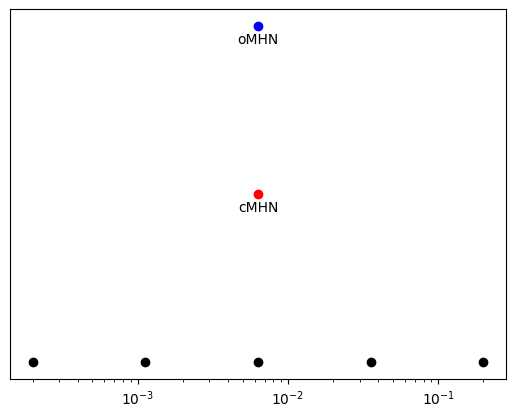

In [19]:
import matplotlib.pyplot as plt

# plot original lambda sequence
plt.scatter(lambda_sequence, np.full(len(lambda_sequence), 1), color='black')

# plot cross-validated lambdas
plt.scatter(cMHN_lambda, 2, color='red')
plt.scatter(oMHN_lambda, 3, color='blue')

# labels
plt.text(cMHN_lambda, 1.9, "cMHN", ha='center')
plt.text(oMHN_lambda, 2.9, "oMHN", ha='center')

# log scale
plt.xscale('log')
plt.yticks([])
plt.ylabel('')

### Final model training

We can now train the final models, using the optimal lambdas from cross-validation we have just confirmed. Then, we'll save the main output, the Θ-matrix, as .csv file, alongside a log file in .json format.

In [26]:
# train cMHN
cMHN_opt.train(lam=cMHN_lambda)
# save output
cMHN_opt.result.save(filename="cMHN.csv")

# train oMHN
oMHN_opt.train(lam=oMHN_lambda)
# save output
oMHN_opt.result.save(filename="oMHN.csv")

Let's inspect the outputs. First, let's look at the log files which tell us about important technical details of the training process:

In [21]:
import json
import pprint

with open('cMHN_meta.json') as f:
    cMHN_log = json.load(f)

pprint.pprint(cMHN_log)

{'init': None,
 'lambda': 0.006324556903056528,
 'maxit': 5000,
 'message': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
 'nit': 153,
 'reltol': 1e-07,
 'score': 4.354283992061328,
 'status': 0}


Let's go through these one by one:
- `'init': ...` - tells us about the initial state of Θ at the start of training. By default (`'init': None`), MHN initializes training with the "independence model" - in which the diagonal entries of Θ are simply set to the emprical odds and the rest of Θ is empty. Alternatively, users have the option to specify some prior parameterization of Θ using the `set_init_theta()` function.
- `'lambda': ...` - just shows us the input regularization strength we previously determined through CV.
- `'maxit': ...` - is the specified maximum number of gradient steps before the training is automatically terminated (default: 5000). 
- `'message': ...` - is the termination message obtained internally from `scipy.optimize.minimize()`. `CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH` is the expected value, which means that the optimization terminated successfully due to parameter convergence. In case other values pop up here, the __[scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)__ should be consulted. 
- `'nit': ...` - tells us about the number of gradient steps taken before termination.
- `'reltol': ...` - informs us about the input upper bound for parameter changes that are still considered as converged, see the __[scipy documentation](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html#optimize-minimize-bfgs)__. This parameter can be changed from default (1e-07) in the `train()` function but we advise inexperienced users not to do so. 
- `'score': ...` - informs us about the input data likelihood under the final model. Specifically, it shows the negative logarithm of the sum of likelihoods over all observations (to be minimized during training - the lower, the better). 
- `'status': ...` - ???
<br><br>
Now, let's look at the same output for oMHN:

In [22]:
with open('oMHN_meta.json') as f:
    oMHN_log = json.load(f)

pprint.pprint(oMHN_log)

{'init': '[[-0.37  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    '
         '0.  ]\n'
         ' [ 0.   -0.66  0.    0.    0.    0.    0.    0.    0.    0.    0.    '
         '0.  ]\n'
         ' [ 0.    0.   -0.99  0.    0.    0.    0.    0.    0.    0.    0.    '
         '0.  ]\n'
         ' [ 0.    0.    0.   -1.63  0.    0.    0.    0.    0.    0.    0.    '
         '0.  ]\n'
         ' [ 0.    0.    0.    0.   -2.18  0.    0.    0.    0.    0.    0.    '
         '0.  ]\n'
         ' [ 0.    0.    0.    0.    0.   -1.94  0.    0.    0.    0.    0.    '
         '0.  ]\n'
         ' [ 0.    0.    0.    0.    0.    0.   -2.65  0.    0.    0.    0.    '
         '0.  ]\n'
         ' [ 0.    0.    0.    0.    0.    0.    0.   -2.68  0.    0.    0.    '
         '0.  ]\n'
         ' [ 0.    0.    0.    0.    0.    0.    0.    0.   -2.65  0.    0.    '
         '0.  ]\n'
         ' [ 0.    0.    0.    0.    0.    0.    0.    0.    0.   -2.79  0.    '
         '0.  ]\n'


We can see e.g., that the oMHN run needed a few more steps to converge and achieved a slightly better score. 

## Inspecting the Θ-matrix

To visualise the main MHN output which details all inferred parameters (i.e., event accumulation rates and rate changes between events), we can simply call `plot()`:

In [23]:
cMHN_opt.result.plot()

AttributeError: 'MHN' object has no attribute 'plot'

By default, `plot()` visualizes the logarithmised form of Θ - this can be changed with `logarithmic = False`. The logarithmic version is also written to file by `save()`. <br><br>
We read the matrix as follows: The cell in row x and column y shows the (logarithmized) multiplicative effect that presence of event y has on the rate of event x. For example, presence of STK11 increases the rate of KEAP1 to `e^2.16 = 8.67 = 867%`. Conversely, presence of BRAF decreases the rate of KRAS to `e^-1.47 = 0.23 = 23%`. The exception to this reading rule is the diagonal, which shows the base rates of the corresponding event. 

In [ ]:
oMHN_opt.result.plot()

With oMHNs, we have an additional bottom row showing the effects on the observation event. For example, presence of TP53 increases the rate of observing the given cancer to `e^0.75 = 2.12 = 212%`. 
<br><br>
Comparing the two matrices, they look quite different at the first glance. Some differences are due to choice of penalty form (L1 vs symmetrical) and some others are due to choice of framework (cMHN vs oMHN). For instance, we can see that the positive relationship between STK11 and KEAP1 is explained by a unidirectional, strong effect with the L1 penalty while it is explained by symmetric, bidirectional and more moderate effects with the symmetrical penalty. In general, the symmetrical-penalty-trained oMHN is (expectedly) much more symmetric.<br> <br>
Furthermore, we can see that the cMHN heatmap has many more negative effects. This is likely because there is a lot of statistical mutual exclusivity in the data that needs to be explained by cMHN. For instance, EGFR is often observed alone or just with 1-2 co-mutations. cMHN can explain this pattern only by introducing negative rate changes between EGFR and other events. oMHN instead can alternatively explain this pattern by fitting an observation-rate-increasing effect to EGFR - in other words, EGFR is often lonely not because it suppresses other events, but because the respective tumor likely becomes observed before other events can accumulate.

## Simulating artificial data from a MHN

We now have an idea of the parameters that were inferred in training. Now, we can use them to generate artificial data. There are two main purposes for this:
1. **Evaluating the fit** - comparing statistical pattern between real and simulated data can be useful to validate that MHN actually fits the data it was trained on.
2. **Exploring event orderings** - we can simulate cancers while keeping track of the ordering in which events accumulate, giving us the possibility to answer related questions.

### Evaluating MHN fitting quality
Let's now first simulate some simple (final) observations without orderings:

In [ ]:
# simulate 500 samples for cMHN
cMHN_sim_observations = cMHN_opt.result.sample_artificial_data(
    500, as_dataframe=True)
print("cMHN simulations:")
cMHN_sim_observations.head()

In [ ]:
# simulate 500 samples for oMHN
oMHN_sim_observations = oMHN_opt.result.sample_artificial_data(
    500, as_dataframe=True)
print("oMHN simulations:")
oMHN_sim_observations.head()

We have simulated as many input observations, once for cMHN and oMHN each. Let's now conduct a simple Fisher's test to check if co-occurrence patterns in the input data were recreated. First, we perform the analysis on the original input data:

In [ ]:
from scipy.stats import fisher_exact

# make the cross-table on input data
input_crosstable = pd.crosstab(input_subset['STK11'], input_subset['KEAP1'])

# print results
print("Cross-table of STK11 and KEAP1 mutations in original data:")
print(input_crosstable)

# perform Fisher's exact test
odds_ratio, p_value = fisher_exact(input_crosstable)

# print results
print("Fisher's exact test:")
print("Odds Ratio:", odds_ratio)
print("p-value:", p_value)

We can see that there is a significant enrichment in the co-occurrence of the two mutations. Now, let's see if we got similar patterns in the cMHN simulations:

In [ ]:
# make the cross-table on cMHN data
cMHN_crosstable = pd.crosstab(
    cMHN_sim_observations['STK11'], cMHN_sim_observations['KEAP1'])

# print results
print("Cross-table of STK11 and KEAP1 mutations in data simulated from cMHN:")
print(cMHN_crosstable)

# perform Fisher's exact test
odds_ratio, p_value = fisher_exact(cMHN_crosstable)

# print results
print("Fisher's exact test:")
print("Odds Ratio:", odds_ratio)
print("p-value:", p_value)

... and we do the same for oMHN:

In [ ]:
# make the cross-table on oMHN data
oMHN_crosstable = pd.crosstab(
    oMHN_sim_observations['STK11'], oMHN_sim_observations['KEAP1'])

# print results
print("Cross-table of STK11 and KEAP1 mutations in data simulated from oMHN:")
print(oMHN_crosstable)

# perform Fisher's exact test
odds_ratio, p_value = fisher_exact(oMHN_crosstable)

# print results
print("Fisher's exact test:")
print("Odds Ratio:", odds_ratio)
print("p-value:", p_value)

Indeed, we can see that both simulations faithfully recreated the original significant enrichment. Also the absolute numbers shown in the simulated cross-tables resemble the original data. 

### Exploring event orderings

Next, let's use the simulations to get novel insights from MHN that are not contained in the input data (but learned from it). Specifically, we can use MHN e.g., to assess trends in the orderings of events. The possible questions are manifold, but let's demonstrate here a simple one: 
- **What is the probability that event A preceded B, given that an observation (cancer) has accumulated both?**
To answer this question, we simply
1. Simulate many observations from a MHN while keeping track of orderings - here we need a lot now but fortunately the simulation is very fast
2. Condition the output to those who have both A and B
3. Under the condition, calculate the fraction of trajectories where A preceded B

In [ ]:
# simulate from cMHN
c_trajectories, c_times = cMHN_opt.result.sample_trajectories(
    100000, [], output_event_names=True)

# condition on trajectories which contain KRAS and TP53
indices = np.array([i for i, trajectory in enumerate(
    c_trajectories) if 'KRAS' in trajectory and 'TP53' in trajectory])
conditioned_trajectories = [c_trajectories[index] for index in indices]

# of those, count in how many KRAS preceded TP53 and then get the fraction
count_KRAS_first = sum(trajectory.index('KRAS') < trajectory.index(
    'TP53') for trajectory in conditioned_trajectories)
fraction_KRAS_first = count_KRAS_first / len(conditioned_trajectories)

print("cMHN: simulation-derived P(KRAS before TP53 | KRAS, TP53 present): ")
fraction_KRAS_first

Now, we do the same for oMHN:

In [ ]:
# simulate from cMHN
o_trajectories, o_times = oMHN_opt.result.sample_trajectories(
    100000, [], output_event_names=True)

# condition on trajectories which contain KRAS and TP53
indices = np.array([i for i, trajectory in enumerate(
    o_trajectories) if 'KRAS' in trajectory and 'TP53' in trajectory])
conditioned_trajectories = [o_trajectories[index] for index in indices]

# of those, count in how many KRAS preceded TP53 and then get the fraction
count_KRAS_first = sum(trajectory.index('KRAS') < trajectory.index(
    'TP53') for trajectory in conditioned_trajectories)
fraction_KRAS_first = count_KRAS_first / len(conditioned_trajectories)

print("oMHN: simulation-derived P(KRAS before TP53 | KRAS, TP53 present): ")
fraction_KRAS_first

We can see that both models encode trajectories where either KRAS or TP53 can come first. However, the oMHN suggests that KRAS slightly tends to come first, while the cMHN leans the other way.

## Predicting the next event for a given MHN state

In principle, MHNs are capable of estimating the future progression of any state represented by a given MHN. For instance, simulations with non-empty starting states could be used. Additionally, we have implemented a convenience function that for a given state, returns the probabilities for all possible next events. <br> <br>

To predict the next event for a state that already has KRAS and STK11, we'll give the function an array which is all zeroes apart from the respective columns. Let's check which indices we need:

In [ ]:
print(input_subset.columns)

We need the second and fourth entry to be 1, all others be 0. The function can output a simple array, or a dataframe that also contains event names (controlled with `as_dataframe=True`). Further, we can treat the state as unobserved, so that observation itself is also a legitimate next event (controlled with `allow_observation=True`)

In [ ]:
# specify state of interest
state_of_interest = np.array(
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=np.int32)

# get the cMHN predictions
cMHN_predictions = cMHN_opt.result.compute_next_event_probs(
    state_of_interest, as_dataframe=True)

# show
print("cMHN predictions:")
print(cMHN_predictions)

# get the cMHN predictions, this time with possible observation
cMHN_predictions = cMHN_opt.result.compute_next_event_probs(
    state_of_interest, as_dataframe=True, allow_observation=True)

# show
print("cMHN predictions w/ observation:")
print(cMHN_predictions)

Let's do it again for oMHN: 

In [ ]:
# get the oMHN predictions
oMHN_predictions = oMHN_opt.result.compute_next_event_probs(
    state_of_interest, as_dataframe=True)

# show
print("oMHN predictions:")
print(oMHN_predictions)

# get the cMHN predictions, this time with possible observation
oMHN_predictions = oMHN_opt.result.compute_next_event_probs(
    state_of_interest, as_dataframe=True, allow_observation=True)

# show
print("oMHN predictions w/ observation:")
print(oMHN_predictions)

We can see that both models favor KEAP1 as possible next event, although it is generally quite rare. This is because both models fit a positive interaction between STK11 and KEAP1. However, cMHN emphasizes this influence whereas in oMHN the effect is more moderate and TP53 is the next most likely event (excluding observation). We can also see that both models agree on that EGFR is unlikely to follow, although it is generally quite frequent. This is because both models fit a negative interaction between KRAS and EGFR. 